# Demo


The purpose of this notebook is to create a minimum working example of seaglider data in OG1 format. The test case is to convert sg015 data from the Labrador Sea in September 2004.

- OG1 format is a newly agreed format (since June 2024) for glider data sets from various platforms (e.g., Seaglider, Slocum, Seaexplorer).  It lives on github here: (https://github.com/OceanGlidersCommunity/OG-format-user-manual).
- OG1 manual: https://oceangliderscommunity.github.io/OG-format-user-manual/OG_Format.html


In [2]:
import sys
import importlib
sys.path.append('/Users/eddifying/Cloudfree/gitlab-cloudfree/seagliderOG1')
import glidertools as gt
#importlib.reload(fetchers)
#importlib.reload(plotters)

In [13]:
import matplotlib.pyplot as plt
import numpy as np
from seagliderOG1 import fetchers
from seagliderOG1 import tools
from seagliderOG1 import plotters
import xarray as xr
import os

#from pathlib import Path

## Load seaglider data in native format

This has three ways to load a glider dataset.

Load an example dataset using `seagliderOG1.fetchers.load_sample_dataset`

Alternatively, use your own with e.g. `ds = xr.open_dataset('/path/to/yourfile.nc')`

### Load a sample dataset

These data are hosted (currently) on dropbox.

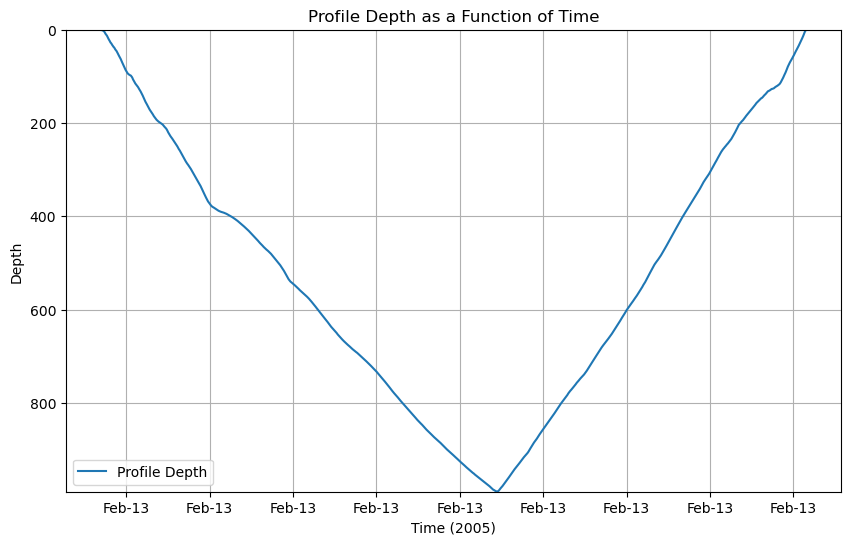

In [4]:
# List of available datasets
file_list = ['p0150500_20050213.nc', 'p0150501_20050213.nc', 'p0150502_20050214.nc', 'p0150503_20050214.nc', 'p0150504_20050215.nc'];

# Loads one dataset (p0150500_20050213.nc)
ds = fetchers.load_sample_dataset()
plotters.plot_profile_depth(ds)

### Load dataset from local machine

- For local data in the directory `input_dir`
- Creates a plot of ctd_depth against ctd_time.


/Users/eddifying/micromamba/envs/glidertest_env/lib/python3.12/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/Users/eddifying/micromamba/envs/glidertest_env/lib/python3.12/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/Users/eddifying/micromamba/envs/glidertest_env/lib/python3.12/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


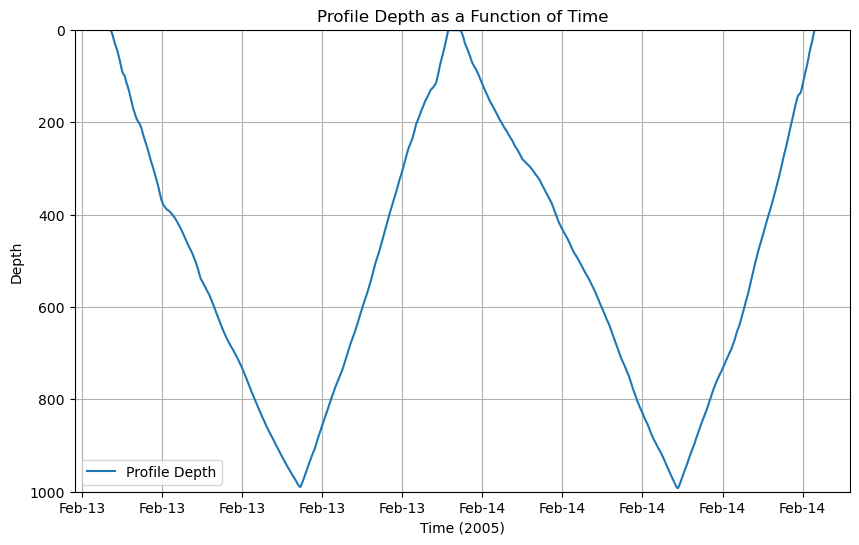

In [27]:
# Specify the input directory on your local machine
input_dir = "/Users/eddifying/Dropbox/data/sg015-ncei-download"

# Load and concatenate all datasets in the input directory
# Optionally, specify the range of profiles to load (start_profile, end_profile)
ds_all = fetchers.load_dataset_from_directory(input_dir, start_profile=500, end_profile=501)

# Simple plot of depth against time
plotters.plot_profile_depth(ds_all)

### Load data from the NCEI server

- Data from the sg015 mission in the Labrador Sea (https://www.ncei.noaa.gov/access/metadata/landing-page/bin/iso?id=gov.noaa.nodc:0111844), dataset identifier gov.noaa.nodc:0111844.


/Users/eddifying/micromamba/envs/glidertest_env/lib/python3.12/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/Users/eddifying/micromamba/envs/glidertest_env/lib/python3.12/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/Users/eddifying/micromamba/envs/glidertest_env/lib/python3.12/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


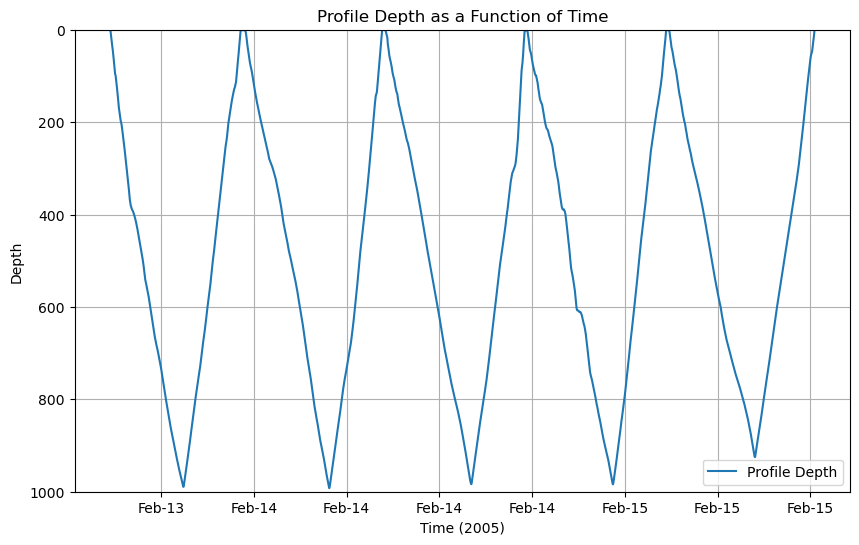

In [6]:
# Specify the server where data are located
server = "https://www.ncei.noaa.gov/data/oceans/glider/seaglider/uw/015/20040924/"

# This was necessary to get an initial file list
# mylist = fetchers.list_files_in_https_server(server)
# fetchers.create_pooch_registry_from_directory("/Users/eddifying/Dropbox/data/sg015-ncei-download/")

# Load and concatenate all datasets from the server, optionally specifying the range of profiles to load
ds_all = fetchers.load_dataset_from_online(server, start_profile=500, end_profile=504)

# Simple plot of depth against time
plotters.plot_profile_depth(ds_all)

## Start to think about renaming variables

### Check what variables are in the file

- Here, I found it easier to use glidertools (https://glidertools.readthedocs.io/en/latest/loading.html#working-with-seaglider-base-station-files) to get a quick look at what's in there.

In [7]:
# Print the variables from one file
filenames = input_dir + "/" + file_list[0]
print(filenames)

gt.load.seaglider_show_variables(filenames)

/Users/eddifying/Dropbox/data/sg015-ncei-download/p0150500_20050213.nc
information is based on file: /Users/eddifying/Dropbox/data/sg015-ncei-download/p0150500_20050213.nc


,dims,units,comment
name,,,
gc_data_pts,gc_event,1,
gc_depth,gc_event,meters,
gc_end_secs,gc_event,seconds since 1970-1-1 00:00:00,End of GC time in GMT epoch format
gc_gcphase,gc_event,,
gc_ob_vertv,gc_event,cm/s,
gc_pitch_ctl,gc_event,cm,
gc_pitch_secs,gc_event,seconds,Elapsed seconds since start of this pitch change
gc_roll_secs,gc_event,seconds,Elapsed seconds since start of this roll change
gc_st_secs,gc_event,seconds since 1970-1-1 00:00:00,Start of GC time in GMT epoch format


### Check the attributes in the basestation file

There was no equivalent in glidertools, so I wrote one and put it in `seagliderOG1.plotters`

In [8]:
file_list = ['p0150500_20050213.nc', 'p0150501_20050213.nc', 'p0150502_20050214.nc', 'p0150503_20050214.nc', 'p0150504_20050215.nc'];
filenames = input_dir + "/" + file_list[0]
plotters.show_attributes(filenames)

information is based on file: /Users/eddifying/Dropbox/data/sg015-ncei-download/p0150500_20050213.nc


,Value
Attribute,
Conventions,CF-1.6
Metadata_Conventions,Unidata Dataset Discovery v1.0
acknowledgment,"NOAA Office of Arctic Research, Grant NA17RJ1232 US Office of Naval Research Grant N00014-02-1-0791"
base_station_micro_version,3705
base_station_version,2.800000
cdm_data_type,Trajectory
contributor_name,Peter Rhines
contributor_role,Co-principal investigator
creator_email,charlie@ocean.washington.edu


In [45]:
from datetime import datetime
importlib.reload(tools)

# Specify the input directory on your local machine
input_dir = "/Users/eddifying/Dropbox/data/sg015-ncei-download"

# Load and concatenate all datasets in the input directory
# Optionally, specify the range of profiles to load (start_profile, end_profile)
ds_all = fetchers.load_dataset_from_directory(input_dir, start_profile=500, end_profile=501)

# Added based on OG1
title = "OceanGliders trajectory file"
platform = "sub-surface gliders"
platform_vocabulary = "https://vocab.nerc.ac.uk/collection/L06/current/27/"

# Modifications or renaming of attributes from Seaglider basestation
time_str = ds_all.time_coverage_start.replace('_', '').replace(':', '').rstrip('Z')
id = ds_all.platform_id + '_' + time_str + '_delayed'
time_coverage_start = time_str
time_coverage_end = ds_all.time_coverage_end.replace('_', '').replace(':', '').rstrip('Z')
site = ds_all.summary
contributor_name = ds_all.creator_name + ', ' + ds_all.contributor_name
contributor_email = ds_all.creator_email
contributor_role = "PI, " + ds_all.contributor_role
contributor_role_vocabulary = "http://vocab.nerc.ac.uk/search_nvs/W08/"
uri = ds_all.uuid
uri_comment = "UUID"
web_link = "https://www.ncei.noaa.gov/access/metadata/landing-page/bin/iso?id=gov.noaa.nodc:0111844"
comment = "history: " + ds_all.history
start_date = time_coverage_start
date_created = ds_all.date_created.replace('_', '').replace(':', '').rstrip('Z')
date_modified = datetime.now().strftime('%Y%m%dT%H%M%S')
featureType = "trajectory"
Conventions = "CF-1.10,OG-1.0"
landstation_version = ds_all.base_station_version + ds_all.base_station_micro_version
glider_firmware_version = ds_all.seaglider_software_version
rtqc_method = "No QC applied"
rtqc_method_doi = "n/a"
doi = "none yet"
data_url = ""

attr_to_add = {
    "title": title,
    "platform": platform, 
    "platform_vocabulary": platform_vocabulary,
    "id": id,
    "contributor_email": contributor_email,
    "contributor_role_vocabulary": contributor_role_vocabulary,
    "uri": uri,
    "uri_comment": uri_comment,
    "web_link": web_link,
    "comment": comment,
    "start_date": start_date,
    "featureType": featureType,
    "landstation_version": landstation_version,
    "glider_firmware_version": glider_firmware_version,
    "rtqc_method": rtqc_method,
    "rtqc_method_doi": rtqc_method_doi,
    "doi": doi,
    "data_url": data_url,
}

attr_as_is = [
    "naming_authority",
    "institution",
    "project",
    "geospatial_lat_min",
    "geospatial_lat_max",
    "geospatial_lon_min",
    "geospatial_lon_max",
    "geospatial_vertical_min",
    "geospatial_vertical_max",
    "license",
    "keywords",
    "keywords_vocabulary",
    "file_version",
    "acknowledgment",
    "date_created",
    "disclaimer",
]

attr_to_change = {
    "time_coverage_start": time_coverage_start,
    "time_coverage_end": time_coverage_end,
    "Conventions": Conventions,
    "date_created": date_created,
    "date_modified": date_modified,
    "contributor_name": contributor_name,
    "contributor_role": contributor_role,
}

# After changing attributes
attr_to_remove = [
    "summary",
    "history",
    "time_coverage_resolution",
    "geospatial_lat_units",
    "geospatial_lon units",
    "geospatial_vertical_units",
    "geospatial_vertical_positive",
    "geospatial_vertical_resolution",
    "geospatial_lat_resolution",
    "geospatial_lon_resolution",
    "creator_name",
    "creator_email",
    "Metadata_Conventions",
]

GPS_variables = [
    "log_gps_lat",
    "log_gps_lon",
    "log_gps_time"
]


# Define the order of attributes
ordered_attributes = [
    "title", "platform", "platform_vocabulary", "id", "naming_authority", 
    "institution", "geospatial_lat_min", "geospatial_lat_max", 
    "geospatial_lon_min", "geospatial_lon_max", "geospatial_vertical_min", 
    "geospatial_vertical_max", "time_coverage_start", "time_coverage_end", 
    "site", "project", "contributor_name", "contributor_email", 
    "contributor_role", "contributor_role_vocabulary", "uri", "data_url", 
    "doi", "rtqc_method", "rtqc_method_doi", "web_link", "comment", 
    "start_date", "date_created", "featureType", "Conventions"
]

# Add the rest of the attributes that are present in the dataset but not in the ordered list
for attr in ds_new_att.attrs:
    if attr not in ordered_attributes:
        ordered_attributes.append(attr)

# Print the ordered attributes
print(ordered_attributes)

ds_new_att = tools.modify_attributes(ds_all, attr_to_add, attr_as_is, attr_to_change, attr_to_remove)

# Reorder the attributes in ds_new_att according to ordered_attributes
new_attrs = {attr: ds_new_att.attrs[attr] for attr in ordered_attributes if attr in ds_new_att.attrs}
for attr in ds_new_att.attrs:
    if attr not in new_attrs:
        new_attrs[attr] = ds_new_att.attrs[attr]
ds_new_att.attrs = new_attrs

print(ds_new_att)

['title', 'platform', 'platform_vocabulary', 'id', 'naming_authority', 'institution', 'geospatial_lat_min', 'geospatial_lat_max', 'geospatial_lon_min', 'geospatial_lon_max', 'geospatial_vertical_min', 'geospatial_vertical_max', 'time_coverage_start', 'time_coverage_end', 'site', 'project', 'contributor_name', 'contributor_email', 'contributor_role', 'contributor_role_vocabulary', 'uri', 'data_url', 'doi', 'rtqc_method', 'rtqc_method_doi', 'web_link', 'comment', 'start_date', 'date_created', 'featureType', 'Conventions', 'license', 'keywords', 'keywords_vocabulary', 'file_version', 'acknowledgment', 'disclaimer', 'date_modified', 'uri_comment', 'landstation_version', 'glider_firmware_version']
<xarray.Dataset>
Dimensions:                       (sg_data_point: 2446)
Coordinates:
    longitude                     (sg_data_point) float64 -55.35 ... -55.41
    latitude                      (sg_data_point) float64 58.3 58.3 ... 58.37
    ctd_time                      (sg_data_point) datetime

/Users/eddifying/micromamba/envs/glidertest_env/lib/python3.12/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/Users/eddifying/micromamba/envs/glidertest_env/lib/python3.12/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/Users/eddifying/micromamba/envs/glidertest_env/lib/python3.12/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


In [47]:
importlib.reload(tools)
import datetime
# Define dictionaries for renaming
#ds_single = xr.open_dataset(file_list[0])

dims_rename_dict = {'sg_data_point': 'N_MEASUREMENTS'}
coords_rename_dict = {
    'longitude': 'LONGITUDE',
    'latitude': 'LATITUDE',
    'ctd_time': 'TIME',
    'ctd_depth': 'DEPTH'
}
vars_rename_dict = {
    'conductivity': 'CNDC',
    'temperature': 'TEMP',
    'salinity': 'PSAL', # after thermal lag correction
#    'conductivity_qc': 'CNDC_QC',
#    'salinity_qc': 'PSAL_QC',
#    'temperature_qc': 'TEMP_QC',
    'vert_speed': 'VERT_GLIDER_SPEED', # This is using the hdm
    'horz_speed': 'HORZ_GLIDER_SPEED', # This is using the hdm
    'density': 'DENSITY',
}

def create_renamed_dataset(ds, dims_rename_dict, coords_rename_dict, vars_rename_dict):
    # Apply renaming using the dictionaries
    ds_renamed = ds.rename_dims(dims_rename_dict)
    ds_renamed = ds_renamed.rename_vars(coords_rename_dict)
    ds_renamed = ds_renamed.rename_vars(vars_rename_dict)
    
    # Remove variables not in vars_rename_dict().values
    vars_to_keep = set(vars_rename_dict.values())
    ds_renamed = ds_renamed[vars_to_keep]
    return ds_renamed

# Example usage
ds_renamed = create_renamed_dataset(ds_new_att, dims_rename_dict, coords_rename_dict, vars_rename_dict)
print(ds_renamed)

<xarray.Dataset>
Dimensions:            (N_MEASUREMENTS: 2446)
Coordinates:
    LONGITUDE          (N_MEASUREMENTS) float64 -55.35 -55.35 ... -55.41 -55.41
    LATITUDE           (N_MEASUREMENTS) float64 58.3 58.3 58.3 ... 58.37 58.37
    TIME               (N_MEASUREMENTS) datetime64[ns] 2005-02-13T14:41:52 .....
    DEPTH              (N_MEASUREMENTS) float64 0.7258 0.8185 ... 0.5925 0.5602
Dimensions without coordinates: N_MEASUREMENTS
Data variables:
    HORZ_GLIDER_SPEED  (N_MEASUREMENTS) float64 nan nan nan nan ... nan nan nan
    DENSITY            (N_MEASUREMENTS) float64 nan nan nan nan ... nan nan nan
    CNDC               (N_MEASUREMENTS) float64 nan nan nan nan ... nan nan nan
    VERT_GLIDER_SPEED  (N_MEASUREMENTS) float64 nan nan nan nan ... nan nan nan
    TEMP               (N_MEASUREMENTS) float64 3.496 3.499 ... 3.192 2.934
    PSAL               (N_MEASUREMENTS) float64 nan nan nan nan ... nan nan nan
Attributes: (12/40)
    title:                        OceanGlider

In [48]:
importlib.reload(plotters)

# Check if the file exists and delete it if it does
output_file = os.path.join('../data', 'test.nc')
if os.path.exists(output_file):
    os.remove(output_file)

# Save the dataset to a NetCDF file
ds_renamed.to_netcdf(output_file, mode='w', format='NETCDF4_CLASSIC')

# Show the attributes of the saved NetCDF file
plotters.show_attributes(output_file)


information is based on file: ../data/test.nc


,Attribute,Value
0,title,OceanGliders trajectory file
1,platform,sub-surface gliders
2,platform_vocabulary,https://vocab.nerc.ac.uk/collection/L06/curren...
3,id,SG015_2005-02-13T230253_delayed
4,naming_authority,edu.washington.apl
5,institution,School of Oceanography\nUniversity of Washingt...
6,geospatial_lat_min,58.329533
7,geospatial_lat_max,58.368799
8,geospatial_lon_min,-55.414655
9,geospatial_lon_max,-55.3854


# Basic statistics of dataset

In [ ]:
# Basic plot of the location of the dataset in space/time
#tools.plot_glider_track(ds)


In [ ]:
# Basic diagnostics of the gridding in the dataset
#tools.plot_grid_spacing_histograms(ds)

In [ ]:
# Basic diagnostics of the watermass properties
#tools.plot_ts_histograms(ds)


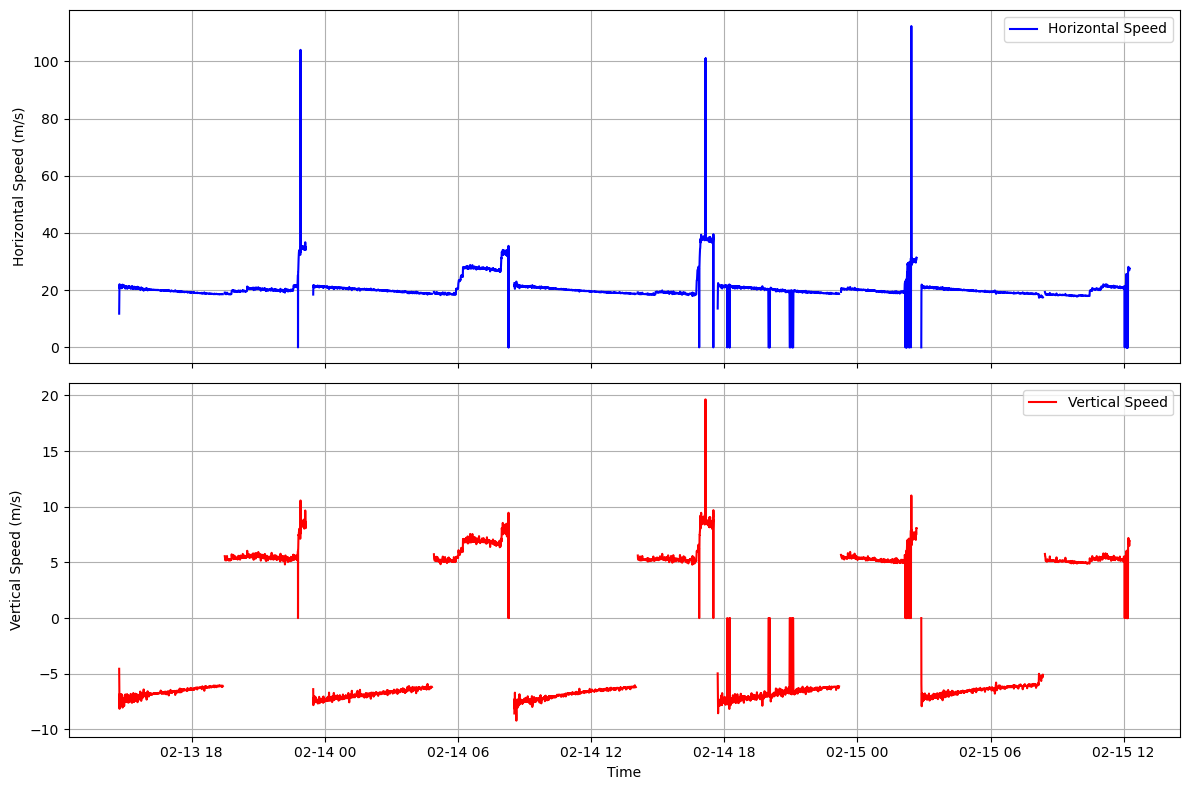

In [10]:
def plot_speeds(ds):
    fig, ax = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

    # Plot horizontal speed
    ax[0].plot(ds['ctd_time'], ds['horz_speed'], label='Horizontal Speed', color='b')
    ax[0].set_ylabel('Horizontal Speed (m/s)')
    ax[0].legend()
    ax[0].grid(True)

    # Plot vertical speed
    ax[1].plot(ds['ctd_time'], ds['vert_speed'], label='Vertical Speed', color='r')
    ax[1].set_ylabel('Vertical Speed (m/s)')
    ax[1].set_xlabel('Time')
    ax[1].legend()
    ax[1].grid(True)

    plt.tight_layout()
    plt.show()

# Example usage
plot_speeds(ds_all)

### Check basic data and water column structure first

In [ ]:
#tools.plot_basic_vars(ds,v_res=1, start_prof=1, end_prof=int(ds.PROFILE_NUMBER.max()))